# Load the data

In [1]:
!pip install -U scikit-learn pandas seaborn matplotlib numpy imblearn mlflow[extras] boto3 awscli --quiet

After running `pip`, restart the notebook kernel by going to the menu at the top.

In [2]:
import os, mlflow

We have now imported `mlflow`. 

MLflow is an open source platform for managing the end-to-end machine learning lifecycle. It tackles four primary functions:

* Tracking experiments to record and compare parameters and results (MLflow Tracking).

* Packaging ML code in a reusable, reproducible form in order to share with other data scientists or transfer to production (MLflow Projects).

* Managing and deploying models from a variety of ML libraries to a variety of model serving and inference platforms (MLflow Models).

* Providing a central model store to collaboratively manage the full lifecycle of an MLflow Model, including model versioning, stage transitions, and annotations (MLflow Model Registry).

In [ ]:
print('The MLflow server is here: {}'.format(os.environ['MLFLOW_TRACKING_URI']))

In [4]:
# The experiment results will be logged into the "Dev" experiment
experiment_name = os.environ.get('MLFLOW_EXPERIMENT_NAME', 'Dev')

e = mlflow.get_experiment_by_name(experiment_name)
if not e:
    experiment_id = mlflow.create_experiment(name=experiment_name)
else:
    experiment_id = e.experiment_id

print('Experiment ID: {}'.format(experiment_id))

Experiment ID: 1


In [5]:
# We now start a run called "fraud_lr"
run = mlflow.start_run(experiment_id=experiment_id, run_name = 'fraud_lr')

In [6]:
import pandas as pd
import numpy as np

In [7]:
import dvc.api
import s3fs
import os

# The credidcard.csv versioning metadata is kept in a git repository in os.environ['DATA_REPO'].
# We are pulling version 1.0 of the data and the data itself is from a S3 bucket that is returned
# by dvc.api.get_url()
resource_url = dvc.api.get_url(
    path='creditcard.csv',
    repo=os.environ['DATA_REPO'],
    rev='v1.0')

print("Data is from this S3 bucket:\n{}".format(resource_url))

# Pandas doens't support endpoint_url
# https://github.com/pandas-dev/pandas/pull/29050
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': os.environ['S3_ENDPOINT_URL']})
df = pd.read_csv(fs.open(resource_url))

In [8]:
features = df.columns.values

# Finding features with the highest correlation

In [9]:
def most_corr(param, n):
    class_corr = df.corr()[param].sort_values(ascending=False)
    list_class = []
    for i in features:
        if(np.abs(class_corr[i]) >= n): 
           list_class.append(i)
    return list_class
# Select features with correlation higher than 0.1 (positive correlation) or lower than -0.1 (negative correlation)
selected_features = most_corr('Class', 0.1)
selected_features

['V1',
 'V3',
 'V4',
 'V7',
 'V10',
 'V11',
 'V12',
 'V14',
 'V16',
 'V17',
 'V18',
 'Class']

In [10]:
dataset = df[selected_features]

# Building your first baseline Logistic Regression model

In [11]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, recall_score, precision_score, \
    average_precision_score, precision_recall_curve, f1_score, auc, \
    roc_curve, roc_auc_score, confusion_matrix, accuracy_score

In [12]:
RANDOM_SEED = 42
mlflow.log_param('RANDOM_SEED', RANDOM_SEED)

In [13]:
TEST_SIZE = 0.3
mlflow.log_param('TEST_SIZE', TEST_SIZE)

## Split the data into X and y

In [14]:
X_train, X_test, y_train, y_test = train_test_split(dataset.drop('Class',1) , dataset['Class'], test_size=TEST_SIZE, random_state=RANDOM_SEED)

In [15]:
X_train.shape

(199364, 11)

In [16]:
X_test.shape

(85443, 11)

In [17]:
from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression

resampling = SMOTE(sampling_strategy='minority', random_state=RANDOM_SEED)
model = Pipeline([('SMOTE', resampling), ('Logistic Regression', LogisticRegression())])

In [18]:
model.fit(X_train, y_train)

Pipeline(steps=[('SMOTE', SMOTE(random_state=42, sampling_strategy='minority')),
                ('Logistic Regression', LogisticRegression())])

In [19]:
# Let's define the threshold
THRESHOLD = 0.5

In [20]:
# Probabilities 
y_proba_baseline = model.predict_proba(X_test)[:,1]

In [21]:
average_precision = average_precision_score(y_test, y_proba_baseline)
mlflow.log_metric('average_precision', average_precision)

In [22]:
print(classification_report(y_test, y_proba_baseline>THRESHOLD))
print('\n')
print('AUC: {}%'.format(roc_auc_score(y_test, y_proba_baseline)))
print('Precision-Recall: {}'.format(average_precision))
print('\n')

rpt = classification_report(y_test, y_proba_baseline>THRESHOLD, output_dict=True)
for lbl in ['0', '1']:
    mlflow.log_metric(lbl + '_recall', rpt[lbl]['recall'])
    mlflow.log_metric(lbl + '_f1_score', rpt[lbl]['f1-score'])
    mlflow.log_metric(lbl + '_precision', rpt[lbl]['precision'])

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     85307
           1       0.05      0.92      0.10       136

    accuracy                           0.97     85443
   macro avg       0.53      0.95      0.54     85443
weighted avg       1.00      0.97      0.98     85443



AUC: 0.9805122967634543%
Precision-Recall: 0.7694974622008761




## AUC - ROC Curve

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

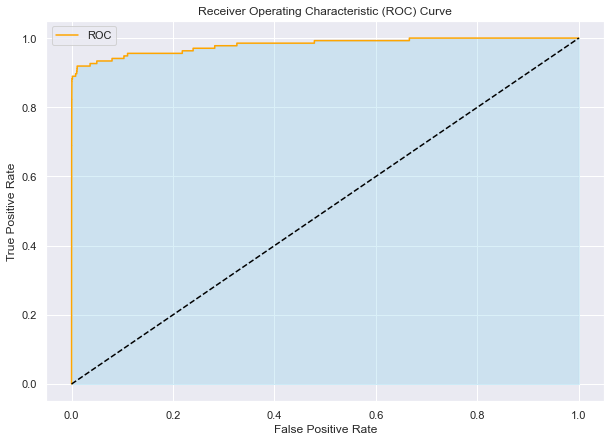

In [24]:
plt.figure(figsize = (10,7))
fpr, tpr, thresholds = roc_curve(y_test, y_proba_baseline)
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.fill_between(fpr, tpr, color='skyblue', alpha=0.3)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## Plot the Precision-Recall curve

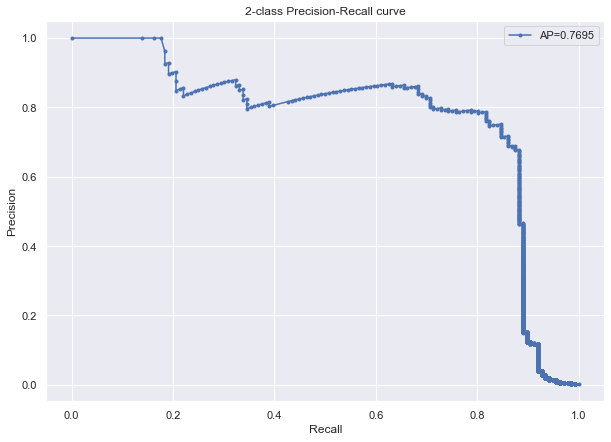

In [25]:
# For unbalanced data
plt.figure(figsize = (10,7))

precision, recall, _ = precision_recall_curve(y_test, y_proba_baseline)
plt.plot(recall, precision, marker='.', label='AP={:.4f}'.format(average_precision))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('2-class Precision-Recall curve')
plt.legend()
plt.show()

## Confusion Matrix

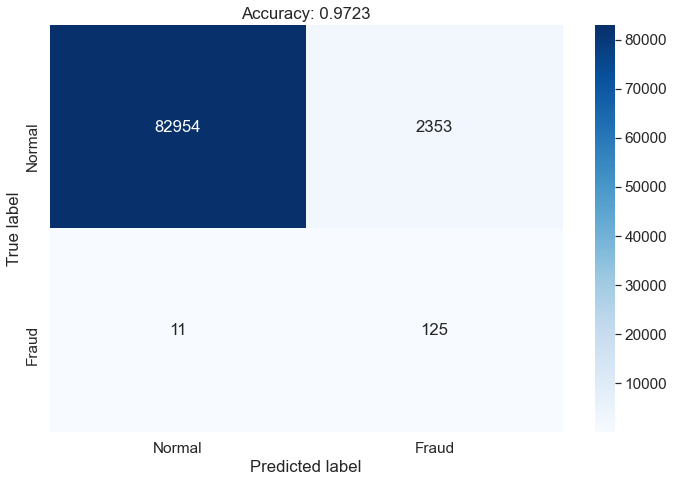

In [26]:
LABELS = ["Normal", "Fraud"]

plt.figure(figsize = (10,7))

cm = confusion_matrix(y_test, y_proba_baseline>THRESHOLD) # rows = truth, cols = prediction    
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))

sns.set(font_scale=1.4)
sns.heatmap(df_cm, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", cmap='Blues')

accuracy = accuracy_score(y_test, y_proba_baseline>THRESHOLD)
mlflow.log_metric('accuracy', accuracy)

plt.title('Accuracy: {:.4f}'.format(accuracy))
plt.ylabel('True label')
plt.xlabel('Predicted label')
    
plt.tight_layout()  
plt.show()

In [27]:
mlflow.end_run()